# Base Model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# os.chdir('/home/bcasares/cs231n_project')
os.chdir('/Users/bcasares/git_folders/cs231n/cs231n_project/')

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

In [4]:
import random
import os

from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from download_images import loadData
from preprocess_data import extractName, getDataLabels

In [5]:
import torch.nn.functional as F  # useful stateless functions

In [6]:
import utils
import json

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [7]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [8]:
# borrowed from http://pytorch.org/tutorials/advanced/neural_style_tutorial.html
# and http://pytorch.org/tutorials/beginner/data_loading_tutorial.html
# define a training image loader that specifies transforms on images. See documentation for more details.
train_transformer = transforms.Compose([
    transforms.Resize(64),  # resize the image to 64x64 (remove if images are already 64x64)
    transforms.RandomVerticalFlip(),  # randomly flip image vertically
    transforms.ToTensor()])  # transform it into a torch tensor

# loader for evaluation, no horizontal flip
eval_transformer = transforms.Compose([
    transforms.Resize(64),  # resize the image to 64x64 (remove if images are already 64x64)
    transforms.ToTensor()])  # transform it into a torch tensor


class HOUSEDataset(Dataset):
    """
    A standard PyTorch definition of Dataset which defines the functions __len__ and __getitem__.
    """
    def __init__(self, data_dir, transform, train):
        """
        Store the filenames of the jpgs to use. Specifies transforms to apply on images.

        Args:
            data_dir: (string) directory containing the dataset
            transform: (torchvision.transforms) transformation to apply on image
        """
        self.data = getDataLabels()
        self.filenames = os.listdir(data_dir)
        self.filenames = [os.path.join(data_dir, f) for f in self.filenames if f.endswith('.jpg')]

        # self.labels = [int(os.path.split(filename)[-1][0]) for filename in self.filenames]
        self.labels = self.getImagesLabel(y_id="log_total_value")
#         print(self.labels)
        self.transform = transform
        self.train = train

    def getImagesLabel(self, id_="rowID", y_id="class_label"):
        ids = list(map(extractName, self.filenames))
        label = self.data[self.data[id_].isin(ids)][y_id].tolist()
        return label

    def __len__(self):
        # return size of dataset
        return len(self.filenames)

    def __getitem__(self, idx):
        """
        Fetch index idx image and labels from dataset. Perform transforms on image.

        Args:
            idx: (int) index in [0, 1, ..., size_of_dataset-1]

        Returns:
            image: (Tensor) transformed image
            label: (int) corresponding label of image
        """
        image = Image.open(self.filenames[idx])  # PIL image
        image = self.transform(image)
        label = self.labels[idx]
        return image, label


def fetch_dataloader(types, data_dir, params):
    """
    Fetches the DataLoader object for each type in types from data_dir.

    Args:
        types: (list) has one or more of 'train', 'val', 'test' depending on which data is required
        data_dir: (string) directory containing the dataset
        params: (Params) hyperparameters

    Returns:
        data: (dict) contains the DataLoader object for each type in types
    """
    dataloaders = {}

    for split in ['train', 'val', 'test']:
        if split in types:
            path = os.path.join(data_dir, "{}".format(split))

            # use the train_transformer if training data, else use eval_transformer without random flip
            if split == 'train':
                dl = DataLoader(HOUSEDataset(path, train_transformer, train=True), batch_size=params.batch_size, shuffle=True,
                                        num_workers=params.num_workers,
                                        pin_memory=params.cuda)
            if split == "val":
                dl = DataLoader(HOUSEDataset(path, eval_transformer, train=False), batch_size=params.batch_size, shuffle=False,
                                num_workers=params.num_workers,
                                pin_memory=params.cuda)
            else:
                dl = DataLoader(HOUSEDataset(path, eval_transformer, train=False), batch_size=params.batch_size, shuffle=False,
                                num_workers=params.num_workers,
                                pin_memory=params.cuda)

            dataloaders[split] = dl

    return dataloaders

In [9]:
json_path = os.path.join("experiments/base_model", 'params.json')
params = utils.Params(json_path)

In [10]:
class Params():
    """Class that loads hyperparameters from a json file.

    Example:
    ```
    params = Params(json_path)
    print(params.learning_rate)
    params.learning_rate = 0.5  # change the value of learning_rate in params
    ```
    """

    def __init__(self, json_path):
        with open(json_path) as f:
            params = json.load(f)
            self.__dict__.update(params)

    def save(self, json_path):
        with open(json_path, 'w') as f:
            json.dump(self.__dict__, f, indent=4)
            
    def update(self, json_path):
        """Loads parameters from json file"""
        with open(json_path) as f:
            params = json.load(f)
            self.__dict__.update(params)

    @property
    def dict(self):
        """Gives dict-like access to Params instance by `params.dict['learning_rate']"""
        return self.__dict__

In [11]:
params = Params(json_path)
params.cuda = torch.cuda.is_available()


In [12]:
loader_train = fetch_dataloader("train", "data/HOUSES_SPLIT_SMALL", params)["train"]
loader_val = fetch_dataloader("val", "data/HOUSES_SPLIT_SMALL", params)["val"]
loader_test = fetch_dataloader("test", "data/HOUSES_SPLIT_SMALL", params)["test"]

/Users/bcasares/anaconda3/envs/cs231n/lib/python3.7/site-packages/ipykernel_launcher.py:83: DtypeWarning: Columns (11,37) have mixed types. Specify dtype option on import or set low_memory=False.
/Users/bcasares/anaconda3/envs/cs231n/lib/python3.7/site-packages/ipykernel_launcher.py:91: DtypeWarning: Columns (11,37) have mixed types. Specify dtype option on import or set low_memory=False.
/Users/bcasares/anaconda3/envs/cs231n/lib/python3.7/site-packages/ipykernel_launcher.py:87: DtypeWarning: Columns (11,37) have mixed types. Specify dtype option on import or set low_memory=False.


In [13]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu


In [14]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
        ########################################################################
        # TODO: Set up the layers you need for a three-layer ConvNet with the  #
        # architecture defined above.                                          #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.conv_w1 = nn.Conv2d(in_channel, channel_1, kernel_size=5, padding=2, bias=True)
        nn.init.kaiming_normal_(self.conv_w1.weight)
        self.conv_w2 = nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1, bias=True)
        nn.init.kaiming_normal_(self.conv_w2.weight)
        self.fc = nn.Linear(channel_2*64*64, num_classes, bias=True)
        nn.init.kaiming_normal_(self.fc.weight)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                          END OF YOUR CODE                            #       
        ########################################################################

    def forward(self, x):
        scores = None
        ########################################################################
        # TODO: Implement the forward function for a 3-layer ConvNet. you      #
        # should use the layers you defined in __init__ and specify the        #
        # connectivity of those layers in forward()                            #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****     
        out = x
        out = self.conv_w1(out)
        out = F.relu(out)
        out = self.conv_w2(out)
        out = F.relu(out)
        out = flatten(out)
        out = self.fc(out)
        scores = out
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return scores


In [15]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc

In [16]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    losses = []
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float)

            scores = model(x)
#             print(scores)
#             print(y)
            loss = F.smooth_l1_loss(scores, y)
#             loss = F.cross_entropy(scores, y)
            losses.append(loss.item())

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()
                
    return losses 

In [17]:
# learning_rate = 3e-3
# channel_1 = 32
# channel_2 = 16

# model = None
# optimizer = None
# ################################################################################
# # TODO: Instantiate your ThreeLayerConvNet model and a corresponding optimizer #
# ################################################################################
# # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# model = ThreeLayerConvNet(3, channel_1, channel_2, 6)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# ################################################################################
# #                                 END OF YOUR CODE                             
# ################################################################################

# losses = train_part34(model, optimizer, epochs=1)

In [57]:
# learning_rates = [1e-2, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
# learning_rates = [1e-2, 2.5e-2, 5e-2, 7.5e-2,  
#                   1e-3, 2.5e-3, 5e-3, 7.5e-3,
#                   1e-4, 2.5e-4, 5e-4, 7.5e-4,
#                   1e-5, 2.5e-5, 5e-5, 7.5e-5,] 
learning_rates = [1e-3] 
channel_1 = 32
channel_2 = 16

model = ThreeLayerConvNet(3, channel_1, channel_2, 1)
losses_model = []
for learning_rate in learning_rates:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = train_part34(model, optimizer, epochs=10)
    losses_model.append(losses)



Iteration 0, loss = 12.1894
Checking accuracy on test set
Got 0 / 20 correct (0.00)

Iteration 0, loss = 153.0196
Checking accuracy on test set
Got 0 / 20 correct (0.00)

Iteration 0, loss = 444.5160
Checking accuracy on test set
Got 0 / 20 correct (0.00)

Iteration 0, loss = 77.4853
Checking accuracy on test set
Got 0 / 20 correct (0.00)

Iteration 0, loss = 9.6511
Checking accuracy on test set
Got 0 / 20 correct (0.00)

Iteration 0, loss = 12.1029
Checking accuracy on test set
Got 0 / 20 correct (0.00)

Iteration 0, loss = 12.0148
Checking accuracy on test set
Got 0 / 20 correct (0.00)

Iteration 0, loss = 11.9111
Checking accuracy on test set
Got 0 / 20 correct (0.00)

Iteration 0, loss = 11.7966
Checking accuracy on test set
Got 0 / 20 correct (0.00)

Iteration 0, loss = 11.6740
Checking accuracy on test set
Got 0 / 20 correct (0.00)

Iteration 0, loss = 11.5454
Checking accuracy on test set
Got 0 / 20 correct (0.00)

Iteration 0, loss = 11.5434
Checking accuracy on test set
Got 0 

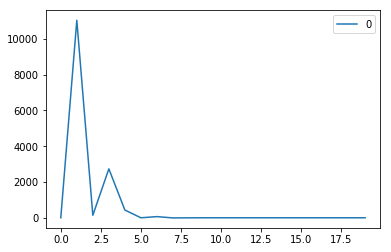

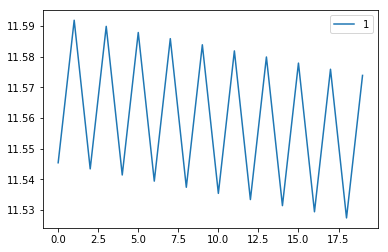

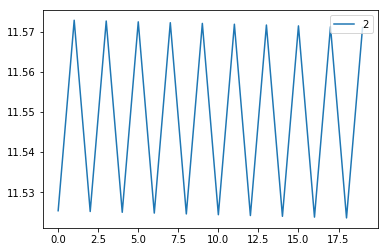

In [58]:
for i, losses in enumerate(losses_model):
    plt.figure()
    plt.plot(losses, label = str(i))
    plt.legend(loc="upper right")